In [1]:
# Jupyter notebook in Jupytext format

## Targeted Feature Overlap Analysis

This notebook specifically investigates two key questions about feature overlaps:
1. **What are the number of overlaps between purely statistical protein feature sets vs. network only?**
2. **Is there overlap between the statistical protein feature set against the clinical feature set?**

The analysis focuses on comparing:
- **Statistical features**: MRMR only method (purely statistical feature selection)
- **Network features**: Network only method (distance 3)
- **Clinical features**: Features derived from clinical gene mappings

## Initialisation and Data Loading

In [2]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path)
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\ode-biomarker-project


In [3]:
from PathLoader import PathLoader #noqa: E402

path_loader = PathLoader("data_config.env", "current_user.env")

In [4]:
from DataLink import DataLink #noqa: E402

data_link = DataLink(path_loader, "data_codes.csv")

In [5]:
# Use the actual directory where results are stored
folder_name = "ThesisResult-FeatureImportanceConsensus"
exp_id = "v1_rf_k500_3methods_split0.3_comparison"

# The results are already in the main folder, no need to create subfolders
main_results_folder = f"{path_loader.get_data_path()}data/results/{folder_name}/"
file_save_path = f"{path_loader.get_data_path()}data/results/{folder_name}/"

In [6]:
# Load required libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')

# Create a new report file for capturing print statements
print_report_path = f"{file_save_path}targeted_overlap_analysis_report_{exp_id}.md"
print_report_file = open(print_report_path, 'w', encoding='utf-8')

# Write header to the print report
print_report_file.write(f"# Targeted Feature Overlap Analysis Report - {exp_id}\n\n")
print_report_file.write(f"**Generated**: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
print_report_file.write("This report provides focused analysis on feature overlaps between statistical, network, and clinical feature sets.\n\n")

def save_and_print(message, report_file=None, level="info"):
    """
    Print message to console and save to report file with proper formatting.
    """
    # Print to console
    print(message)
    
    # Save to report with proper formatting
    if report_file:
        if level == "header":
            report_file.write(f"# {message}\n\n")
        elif level == "section":
            report_file.write(f"## {message}\n\n")
        elif level == "subsection":
            report_file.write(f"### {message}\n\n")
        else:  # info level
            report_file.write(f"{message}\n\n")
    
    return message

## Load Feature Selection Results

In [7]:
save_and_print("## Loading Feature Selection Results", print_report_file, level="section")

# Define experiment parameters
model_name = "RandomForestRegressor"
k_value = 500
split_size = 0.3
network_distance = 3

# Define the methods we're comparing
methods = {
    "network_only_d3": "Network only (distance 3)", 
    "mrmr_only": "MRMR only",
    "mrmr_network_d3": "MRMR + Network (distance 3)"
}

# Define conditions for statistical and network methods
conditions = []
for method_name, method_desc in methods.items():
    if method_name in ["network_only_d3", "mrmr_only"]:  # Focus on these two for our analysis
        conditions.append(f"{model_name}_k{k_value}_{method_name}_split{split_size}_shap")
        conditions.append(f"{model_name}_k{k_value}_{method_name}_split{split_size}_mdi")

save_and_print(f"Loading data for {len(conditions)} conditions:", print_report_file, level="info")

# Load all available data files
data_files = {}

for condition in conditions:
    condition_data = {}
    
    # Try to load consensus feature importance data
    file_types = [
        f"consensus_feature_importance_{condition}.pkl",
        f"total_results_{condition}.pkl",
        f"meta_results_{condition}.pkl"
    ]
    
    for file_type in file_types:
        file_path = f"{main_results_folder}{file_type}"
        if os.path.exists(file_path):
            try:
                condition_data[file_type.replace(f"_{condition}.pkl", "")] = pd.read_pickle(file_path)
                save_and_print(f"✓ Loaded {file_type}", print_report_file, level="info")
            except Exception as e:
                save_and_print(f"✗ Failed to load {file_type}: {e}", print_report_file, level="info")
        else:
            save_and_print(f"✗ File not found: {file_type}", print_report_file, level="info")
    
    data_files[condition] = condition_data

## Loading Feature Selection Results
Loading data for 4 conditions:
✓ Loaded consensus_feature_importance_RandomForestRegressor_k500_network_only_d3_split0.3_shap.pkl
✓ Loaded total_results_RandomForestRegressor_k500_network_only_d3_split0.3_shap.pkl
✓ Loaded meta_results_RandomForestRegressor_k500_network_only_d3_split0.3_shap.pkl
✓ Loaded consensus_feature_importance_RandomForestRegressor_k500_network_only_d3_split0.3_mdi.pkl
✓ Loaded total_results_RandomForestRegressor_k500_network_only_d3_split0.3_mdi.pkl
✓ Loaded meta_results_RandomForestRegressor_k500_network_only_d3_split0.3_mdi.pkl
✓ Loaded consensus_feature_importance_RandomForestRegressor_k500_mrmr_only_split0.3_shap.pkl
✓ Loaded total_results_RandomForestRegressor_k500_mrmr_only_split0.3_shap.pkl
✓ Loaded meta_results_RandomForestRegressor_k500_mrmr_only_split0.3_shap.pkl
✓ Loaded consensus_feature_importance_RandomForestRegressor_k500_mrmr_only_split0.3_mdi.pkl
✓ Loaded total_results_RandomForestRegressor_k500_mrmr_only_spl

## Load Clinical and Network Feature Sets

In [8]:
save_and_print("## Loading Clinical and Network Feature Sets", print_report_file, level="section")

# Add missing imports for clinical feature analysis
import pickle
from typing import List

def extract_uniprot_id(feature_name):
    """
    Extract Uniprot ID from proteomics feature name format: [Gene][UniprotID]:HUMAN
    Example: 'EGFRP00533:HUMAN' -> 'P00533'
    """
    import re
    match = re.search(r'([A-Z][0-9]{5})', feature_name)
    if match:
        return match.group(1)
    return None

def get_clinical_features(X: pd.DataFrame, clinical_genes_df: pd.DataFrame) -> List[str]:
    """
    Extract clinical features from proteomics data based on clinical gene mapping
    """
    # Extract Uniprot IDs from proteomics feature names
    feature_uniprot_ids = {}
    for col in X.columns:
        uniprot_id = extract_uniprot_id(col)
        if uniprot_id:
            feature_uniprot_ids[col] = uniprot_id

    # Get clinical gene Uniprot IDs
    clinical_uniprot_ids = set(clinical_genes_df['UniProt ID'].tolist())

    # Find overlapping Uniprot IDs
    overlapping_ids = clinical_uniprot_ids.intersection(set(feature_uniprot_ids.values()))

    # Create list of clinical features
    clinical_feature_columns = []
    for clinical_id in overlapping_ids:
        matching_features = [feature for feature, uniprot_id in feature_uniprot_ids.items() 
                            if uniprot_id == clinical_id]
        clinical_feature_columns.extend(matching_features)

    return clinical_feature_columns

def get_network_features(max_distance: int = 3) -> List[str]:
    """
    Load network features at specified distance from the network structure file
    """
    # Load network structure
    network_file_path = f"{path_loader.get_data_path()}data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl"
    
    if not os.path.exists(network_file_path):
        save_and_print(f"Network file not found: {network_file_path}", print_report_file, level="info")
        return []
    
    try:
        with open(network_file_path, 'rb') as f:
            nth_degree_neighbours = pickle.load(f)
        
        # Get network features at specified distance
        if max_distance <= len(nth_degree_neighbours):
            network_features = nth_degree_neighbours[max_distance - 1] if nth_degree_neighbours[max_distance - 1] is not None else []
        else:
            network_features = []
        
        # Map network features to proteomics-compatible IDs
        from protein_id_mapper import load_protein_mapping, map_network_features, filter_available_features
        
        mapping_df = load_protein_mapping(path_loader)
        
        if mapping_df is not None:
            mapped_network_features = map_network_features(network_features, mapping_df)
            # Filter to features available in the dataset
            loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
            proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(loading_code)
            proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])
            
            available_network_features = filter_available_features(mapped_network_features, proteomic_feature_data.columns)
            network_features = available_network_features
        else:
            # Load proteomics data for filtering
            loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
            proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(loading_code)
            proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])
            
            available_network_features = [f for f in network_features if f in proteomic_feature_data.columns]
            network_features = available_network_features
        
        return network_features
        
    except Exception as e:
        save_and_print(f"Error loading network features: {e}", print_report_file, level="info")
        return []

## Loading Clinical and Network Feature Sets


In [9]:
# Load clinical gene mapping
clinical_genes_df = pd.read_excel("gene_to_uniprot_mapping.xlsx", sheet_name="Sheet1")
save_and_print(f"Loaded clinical gene mapping with {len(clinical_genes_df)} genes", print_report_file, level="info")

# Load proteomics data for feature analysis
save_and_print("Loading proteomics data for feature analysis...", print_report_file, level="info")
loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(loading_code)
proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])

# Align indices
common_indices = sorted(
    set(proteomic_feature_data.index) & set(proteomic_label_data.index)
)
feature_data = proteomic_feature_data.loc[common_indices]
label_data = proteomic_label_data.loc[common_indices]

save_and_print(f"Loaded proteomics dataset shape: {feature_data.shape}", print_report_file, level="info")

# Get clinical features
clinical_features = get_clinical_features(feature_data, clinical_genes_df)
save_and_print(f"Found {len(clinical_features)} clinical features in the dataset", print_report_file, level="info")

# Get network features (distance 3)
network_features = get_network_features(max_distance=3)
save_and_print(f"Found {len(network_features)} network features at distance 3", print_report_file, level="info")

Loaded clinical gene mapping with 26 genes
Loading proteomics data for feature analysis...
Loaded proteomics dataset shape: (737, 6692)
Found 16 clinical features in the dataset
Found 1299 network features at distance 3


'Found 1299 network features at distance 3'

## Extract Top Features for Comparison

In [10]:
save_and_print("## Extracting Top Features for Comparison", print_report_file, level="section")

def extract_top_features_for_comparison(data_files, top_n=50):
    """
    Extract top features specifically for statistical vs network comparison
    """
    save_and_print("### Extracting Top Features from Feature Selection Results", print_report_file, level="subsection")
    
    # Statistical features (MRMR only)
    mrmr_shap_condition = f"{model_name}_k{k_value}_mrmr_only_split{split_size}_shap"
    mrmr_mdi_condition = f"{model_name}_k{k_value}_mrmr_only_split{split_size}_mdi"
    
    # Network features (Network only)
    network_shap_condition = f"{model_name}_k{k_value}_network_only_d3_split{split_size}_shap"
    network_mdi_condition = f"{model_name}_k{k_value}_network_only_d3_split{split_size}_mdi"
    
    # Extract top features from consensus data
    statistical_features_shap = set()
    statistical_features_mdi = set()
    network_features_shap = set()
    network_features_mdi = set()
    
    # Extract from SHAP
    if mrmr_shap_condition in data_files and 'consensus_feature_importance' in data_files[mrmr_shap_condition]:
        df = data_files[mrmr_shap_condition]['consensus_feature_importance']
        statistical_features_shap = set(df.nlargest(top_n, 'mean_importance').index)
        save_and_print(f"✓ Extracted {len(statistical_features_shap)} top features from MRMR (SHAP)", print_report_file, level="info")
    else:
        save_and_print(f"✗ Could not extract MRMR SHAP features: {mrmr_shap_condition}", print_report_file, level="info")
    
    if network_shap_condition in data_files and 'consensus_feature_importance' in data_files[network_shap_condition]:
        df = data_files[network_shap_condition]['consensus_feature_importance']
        network_features_shap = set(df.nlargest(top_n, 'mean_importance').index)
        save_and_print(f"✓ Extracted {len(network_features_shap)} top features from Network (SHAP)", print_report_file, level="info")
    else:
        save_and_print(f"✗ Could not extract Network SHAP features: {network_shap_condition}", print_report_file, level="info")
    
    # Extract from MDI
    if mrmr_mdi_condition in data_files and 'consensus_feature_importance' in data_files[mrmr_mdi_condition]:
        df = data_files[mrmr_mdi_condition]['consensus_feature_importance']
        statistical_features_mdi = set(df.nlargest(top_n, 'mean_importance').index)
        save_and_print(f"✓ Extracted {len(statistical_features_mdi)} top features from MRMR (MDI)", print_report_file, level="info")
    else:
        save_and_print(f"✗ Could not extract MRMR MDI features: {mrmr_mdi_condition}", print_report_file, level="info")
    
    if network_mdi_condition in data_files and 'consensus_feature_importance' in data_files[network_mdi_condition]:
        df = data_files[network_mdi_condition]['consensus_feature_importance']
        network_features_mdi = set(df.nlargest(top_n, 'mean_importance').index)
        save_and_print(f"✓ Extracted {len(network_features_mdi)} top features from Network (MDI)", print_report_file, level="info")
    else:
        save_and_print(f"✗ Could not extract Network MDI features: {network_mdi_condition}", print_report_file, level="info")
    
    return {
        'statistical_shap': statistical_features_shap,
        'statistical_mdi': statistical_features_mdi,
        'network_shap': network_features_shap,
        'network_mdi': network_features_mdi
    }

# Execute feature extraction
feature_sets = extract_top_features_for_comparison(data_files, top_n=50)

## Extracting Top Features for Comparison
### Extracting Top Features from Feature Selection Results
✓ Extracted 50 top features from MRMR (SHAP)
✓ Extracted 50 top features from Network (SHAP)
✓ Extracted 50 top features from MRMR (MDI)
✓ Extracted 50 top features from Network (MDI)


## Question 1: Statistical vs Network Feature Overlap

In [11]:
save_and_print("## Question 1: Statistical vs Network Feature Overlap", print_report_file, level="section")

def analyze_statistical_vs_network_overlap(feature_sets, top_n=50):
    """
    Answer Question 1: Overlap between purely statistical vs network only
    """
    save_and_print("### Analyzing Statistical vs Network Feature Overlap", print_report_file, level="subsection")
    
    results = {}
    
    for importance_method in ['shap', 'mdi']:
        stat_features = feature_sets[f'statistical_{importance_method}']
        net_features = feature_sets[f'network_{importance_method}']
        
        intersection = stat_features & net_features
        union = stat_features | net_features
        jaccard = len(intersection) / len(union) if len(union) > 0 else 0
        
        results[f'{importance_method}'] = {
            'statistical_count': len(stat_features),
            'network_count': len(net_features),
            'intersection_count': len(intersection),
            'intersection_percentage': len(intersection) / top_n * 100,
            'jaccard_similarity': jaccard,
            'statistical_only': stat_features - net_features,
            'network_only': net_features - stat_features,
            'common_features': intersection
        }
        
        save_and_print(f"**{importance_method.upper()} Importance Method:**", print_report_file, level="info")
        save_and_print(f"- Statistical (MRMR only) features: {len(stat_features)}", print_report_file, level="info")
        save_and_print(f"- Network only features: {len(net_features)}", print_report_file, level="info")
        save_and_print(f"- Overlapping features: {len(intersection)} ({len(intersection) / top_n * 100:.1f}%)", print_report_file, level="info")
        save_and_print(f"- Jaccard similarity: {jaccard:.4f}", print_report_file, level="info")
        save_and_print(f"- Statistical only features: {len(stat_features - net_features)}", print_report_file, level="info")
        save_and_print(f"- Network only features: {len(net_features - stat_features)}", print_report_file, level="info")
        
        if intersection:
            save_and_print(f"- Common features: {', '.join(sorted(list(intersection))[:10])}{'...' if len(intersection) > 10 else ''}", print_report_file, level="info")
        save_and_print("", print_report_file, level="info")
    
    return results

# Execute statistical vs network analysis
stat_vs_net_results = analyze_statistical_vs_network_overlap(feature_sets, top_n=50)

## Question 1: Statistical vs Network Feature Overlap
### Analyzing Statistical vs Network Feature Overlap
**SHAP Importance Method:**
- Statistical (MRMR only) features: 50
- Network only features: 50
- Overlapping features: 16 (32.0%)
- Jaccard similarity: 0.1905
- Statistical only features: 34
- Network only features: 34
- Common features: O60716;CTND1_HUMAN, P18031;PTN1_HUMAN, P19388;RPAB1_HUMAN, P32519;ELF1_HUMAN, P35222;CTNB1_HUMAN, P42771;CDN2A_HUMAN, Q07817;B2CL1_HUMAN, Q13422;IKZF1_HUMAN, Q6WCQ1;MPRIP_HUMAN, Q92556;ELMO1_HUMAN...

**MDI Importance Method:**
- Statistical (MRMR only) features: 50
- Network only features: 50
- Overlapping features: 16 (32.0%)
- Jaccard similarity: 0.1905
- Statistical only features: 34
- Network only features: 34
- Common features: O60716;CTND1_HUMAN, P18031;PTN1_HUMAN, P19388;RPAB1_HUMAN, P32519;ELF1_HUMAN, P33316;DUT_HUMAN, P35222;CTNB1_HUMAN, P42768;WASP_HUMAN, P42771;CDN2A_HUMAN, Q07817;B2CL1_HUMAN, Q13422;IKZF1_HUMAN...



## Question 2: Statistical vs Clinical Feature Overlap

In [12]:
save_and_print("## Question 2: Statistical vs Clinical Feature Overlap", print_report_file, level="section")

def analyze_statistical_vs_clinical_overlap(feature_sets, clinical_features, top_n=50):
    """
    Answer Question 2: Overlap between statistical vs clinical features
    """
    save_and_print("### Analyzing Statistical vs Clinical Feature Overlap", print_report_file, level="subsection")
    
    clinical_set = set(clinical_features)
    save_and_print(f"Clinical feature set size: {len(clinical_set)}", print_report_file, level="info")
    
    results = {}
    
    for importance_method in ['shap', 'mdi']:
        stat_features = feature_sets[f'statistical_{importance_method}']
        
        intersection = stat_features & clinical_set
        union = stat_features | clinical_set
        jaccard = len(intersection) / len(union) if len(union) > 0 else 0
        
        results[f'{importance_method}'] = {
            'statistical_count': len(stat_features),
            'clinical_count': len(clinical_set),
            'intersection_count': len(intersection),
            'intersection_percentage_statistical': len(intersection) / len(stat_features) * 100 if len(stat_features) > 0 else 0,
            'intersection_percentage_clinical': len(intersection) / len(clinical_set) * 100 if len(clinical_set) > 0 else 0,
            'jaccard_similarity': jaccard,
            'statistical_only': stat_features - clinical_set,
            'clinical_only': clinical_set - stat_features,
            'common_features': intersection
        }
        
        save_and_print(f"**{importance_method.upper()} Importance Method:**", print_report_file, level="info")
        save_and_print(f"- Statistical (MRMR only) features: {len(stat_features)}", print_report_file, level="info")
        save_and_print(f"- Clinical features: {len(clinical_set)}", print_report_file, level="info")
        save_and_print(f"- Overlapping features: {len(intersection)}", print_report_file, level="info")
        save_and_print(f"- Overlap as % of statistical features: {len(intersection) / len(stat_features) * 100:.1f}%", print_report_file, level="info")
        save_and_print(f"- Overlap as % of clinical features: {len(intersection) / len(clinical_set) * 100:.1f}%", print_report_file, level="info")
        save_and_print(f"- Jaccard similarity: {jaccard:.4f}", print_report_file, level="info")
        
        if intersection:
            save_and_print(f"- Clinical features captured by statistical method: {', '.join(sorted(list(intersection))[:10])}{'...' if len(intersection) > 10 else ''}", print_report_file, level="info")
        save_and_print("", print_report_file, level="info")
    
    return results

# Execute statistical vs clinical analysis
stat_vs_clin_results = analyze_statistical_vs_clinical_overlap(feature_sets, clinical_features, top_n=50)

## Question 2: Statistical vs Clinical Feature Overlap
### Analyzing Statistical vs Clinical Feature Overlap
Clinical feature set size: 16
**SHAP Importance Method:**
- Statistical (MRMR only) features: 50
- Clinical features: 16
- Overlapping features: 1
- Overlap as % of statistical features: 2.0%
- Overlap as % of clinical features: 6.2%
- Jaccard similarity: 0.0154
- Clinical features captured by statistical method: P42771;CDN2A_HUMAN

**MDI Importance Method:**
- Statistical (MRMR only) features: 50
- Clinical features: 16
- Overlapping features: 1
- Overlap as % of statistical features: 2.0%
- Overlap as % of clinical features: 6.2%
- Jaccard similarity: 0.0154
- Clinical features captured by statistical method: P42771;CDN2A_HUMAN



## Visualization of Overlap Results

## Visualization of Overlap Results
### Creating Targeted Overlap Visualizations


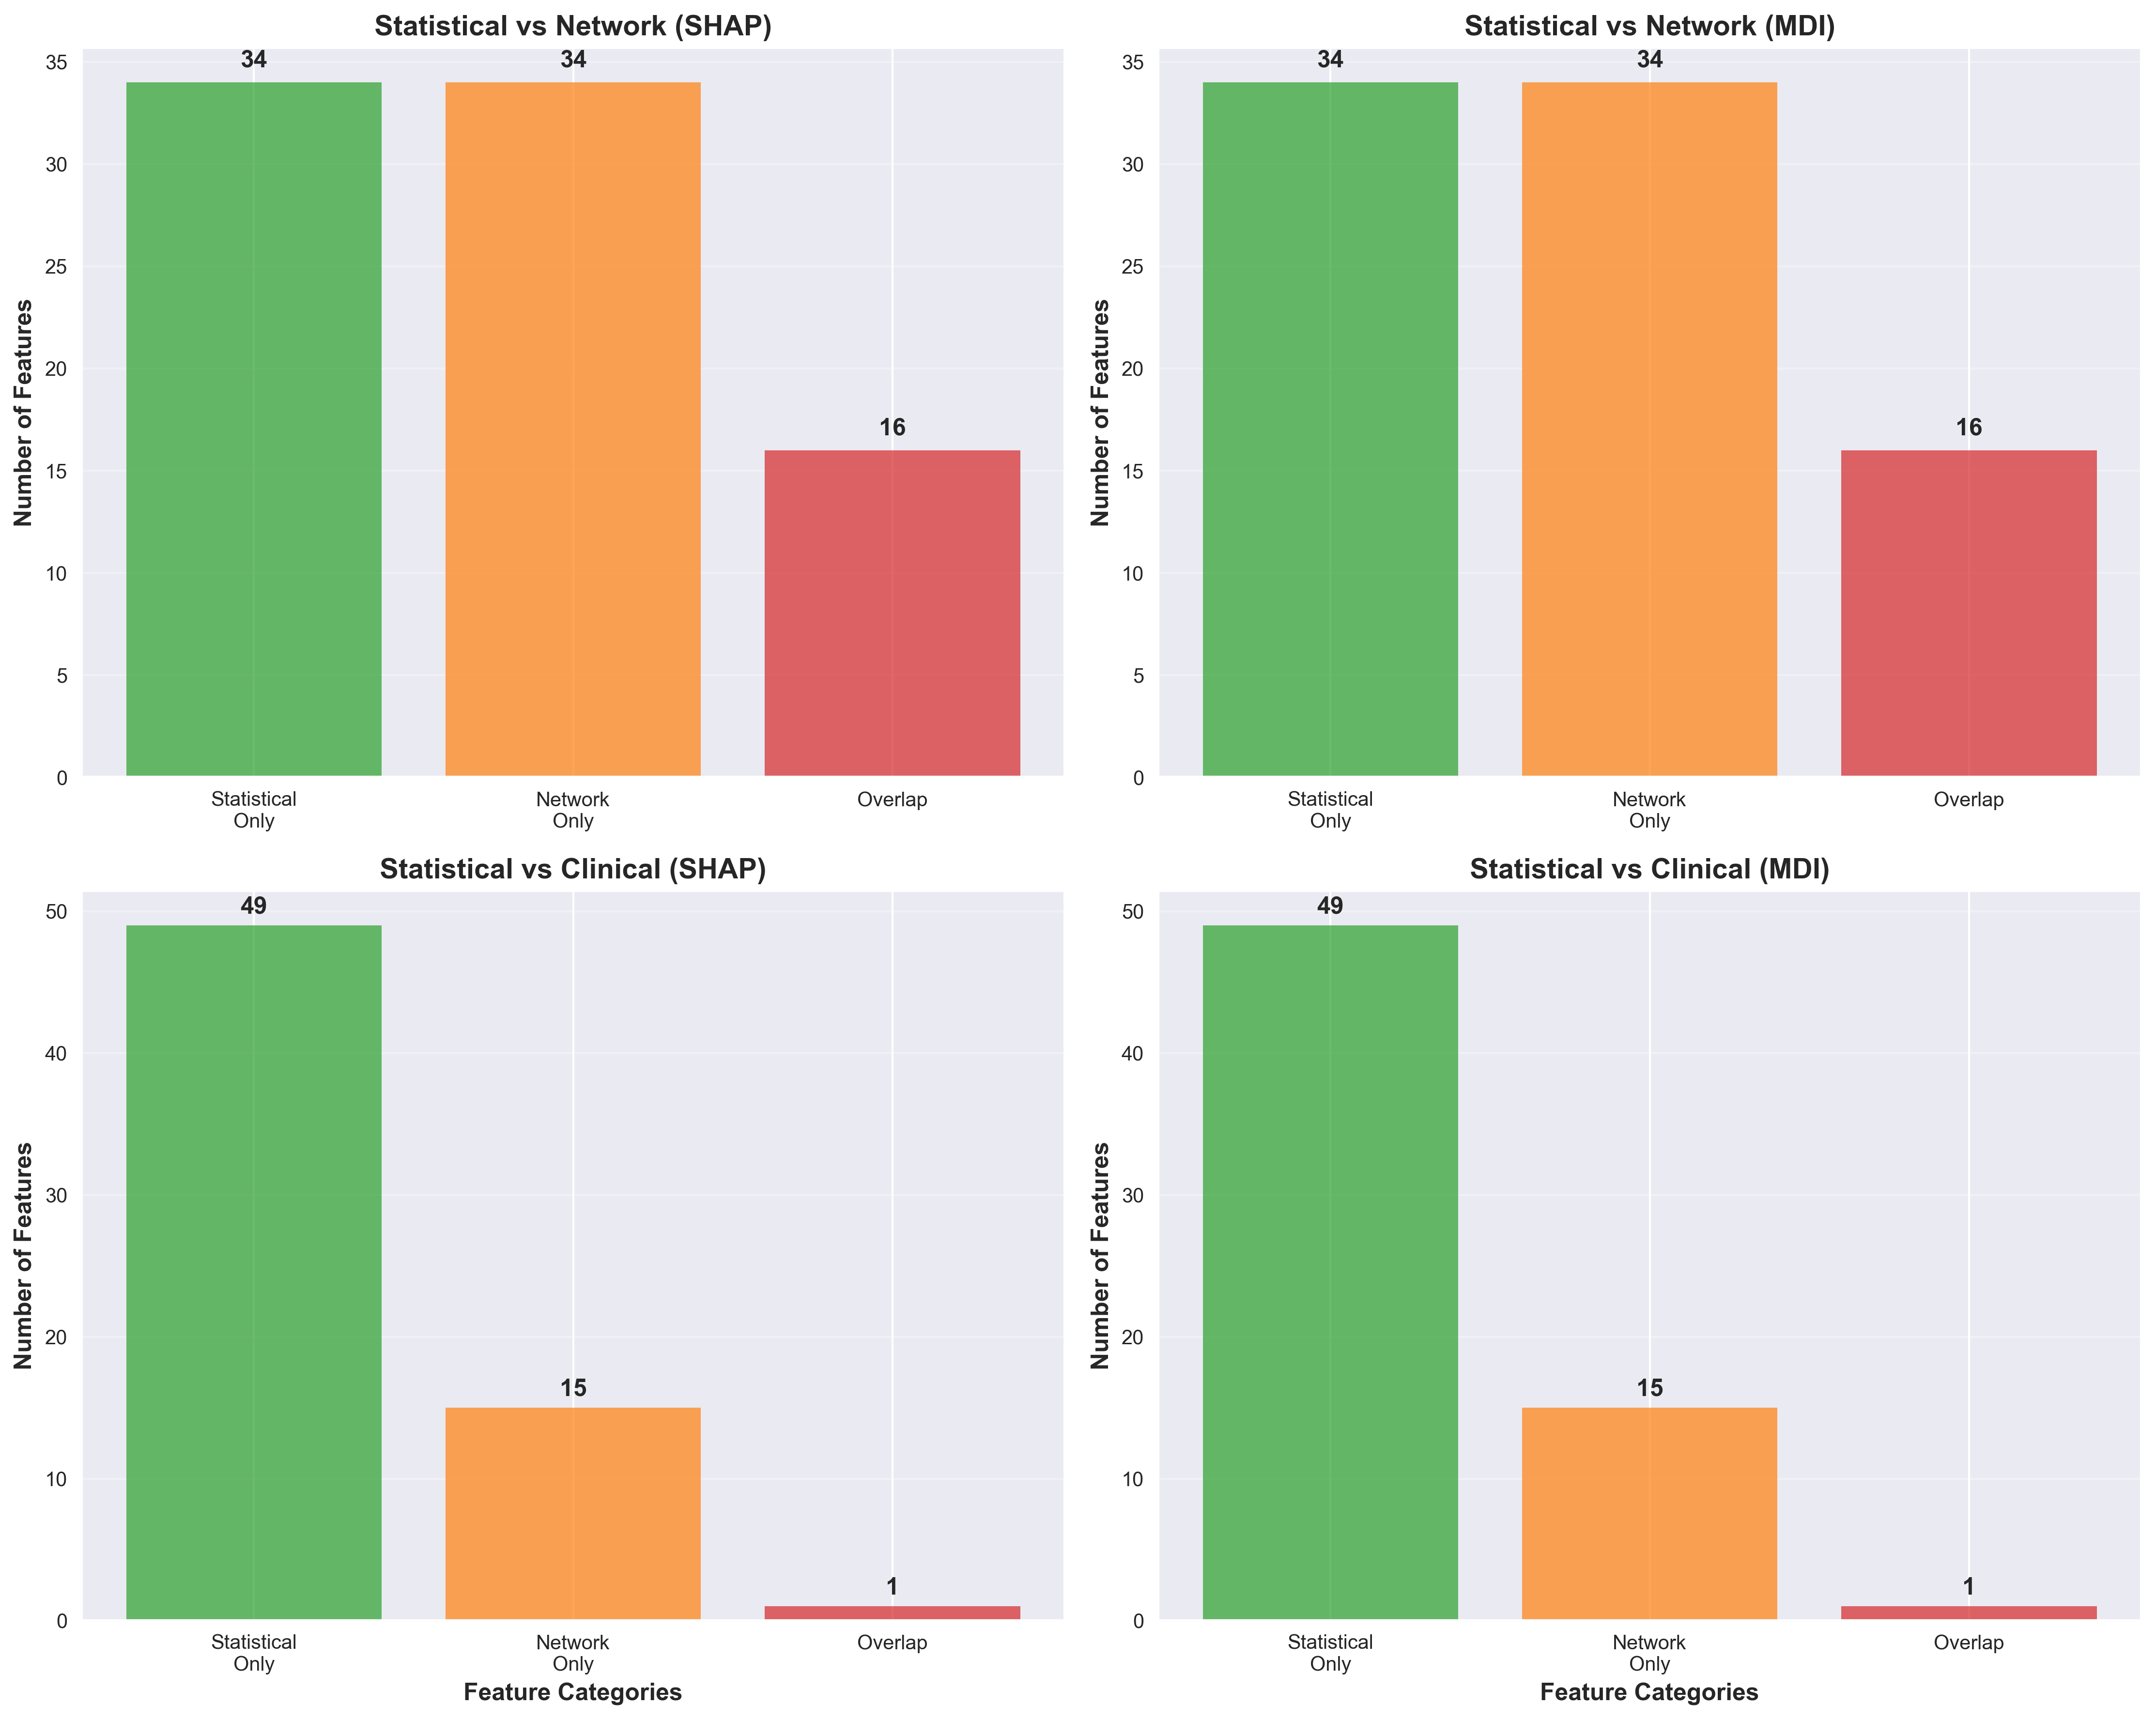

✓ Created targeted overlap analysis visualization


In [13]:
save_and_print("## Visualization of Overlap Results", print_report_file, level="section")

def create_targeted_visualizations(stat_vs_net_results, stat_vs_clin_results, feature_sets, save_path):
    """
    Create targeted visualizations for the two specific comparisons
    """
    save_and_print("### Creating Targeted Overlap Visualizations", print_report_file, level="subsection")
    
    # Set up plotting style
    plt.style.use('seaborn-v0_8')
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.linewidth'] = 1.5
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
    
    # Statistical vs Network - SHAP
    ax1 = axes[0, 0]
    stat_count = len(feature_sets['statistical_shap'])
    net_count = len(feature_sets['network_shap'])
    intersection_count = len(stat_vs_net_results['shap']['common_features'])
    
    # Create bar chart for SHAP
    categories = ['Statistical\nOnly', 'Network\nOnly', 'Overlap']
    counts = [stat_count - intersection_count, net_count - intersection_count, intersection_count]
    colors = ['#2ca02c', '#ff7f0e', '#d62728']
    
    bars1 = ax1.bar(categories, counts, color=colors, alpha=0.7)
    ax1.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
    ax1.set_title('Statistical vs Network (SHAP)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(counts):
        ax1.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
    
    # Statistical vs Network - MDI
    ax2 = axes[0, 1]
    stat_count_mdi = len(feature_sets['statistical_mdi'])
    net_count_mdi = len(feature_sets['network_mdi'])
    intersection_count_mdi = len(stat_vs_net_results['mdi']['common_features'])
    
    counts_mdi = [stat_count_mdi - intersection_count_mdi, net_count_mdi - intersection_count_mdi, intersection_count_mdi]
    
    bars2 = ax2.bar(categories, counts_mdi, color=colors, alpha=0.7)
    ax2.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
    ax2.set_title('Statistical vs Network (MDI)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(counts_mdi):
        ax2.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
    
    # Statistical vs Clinical - SHAP
    ax3 = axes[1, 0]
    clinical_count = len(stat_vs_clin_results['shap']['clinical_only']) + len(stat_vs_clin_results['shap']['common_features'])
    intersection_clin_shap = len(stat_vs_clin_results['shap']['common_features'])
    
    counts_clin_shap = [stat_count - intersection_clin_shap, clinical_count - intersection_clin_shap, intersection_clin_shap]
    
    bars3 = ax3.bar(categories, counts_clin_shap, color=colors, alpha=0.7)
    ax3.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
    ax3.set_title('Statistical vs Clinical (SHAP)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Feature Categories', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(counts_clin_shap):
        ax3.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
    
    # Statistical vs Clinical - MDI
    ax4 = axes[1, 1]
    intersection_clin_mdi = len(stat_vs_clin_results['mdi']['common_features'])
    
    counts_clin_mdi = [stat_count_mdi - intersection_clin_mdi, clinical_count - intersection_clin_mdi, intersection_clin_mdi]
    
    bars4 = ax4.bar(categories, counts_clin_mdi, color=colors, alpha=0.7)
    ax4.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
    ax4.set_title('Statistical vs Clinical (MDI)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Feature Categories', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(counts_clin_mdi):
        ax4.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{save_path}targeted_overlap_analysis_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("✓ Created targeted overlap analysis visualization", print_report_file, level="info")

# Create visualizations
create_targeted_visualizations(stat_vs_net_results, stat_vs_clin_results, feature_sets, file_save_path)

## Statistical Significance Testing

In [14]:
save_and_print("## Statistical Significance Testing", print_report_file, level="section")

def perform_statistical_significance_tests(stat_vs_net_results, stat_vs_clin_results, feature_sets, clinical_features):
    """
    Perform statistical tests to determine if overlaps are significant
    """
    save_and_print("### Statistical Significance Analysis", print_report_file, level="subsection")
    
    # Get total number of features in the dataset
    total_features = len(feature_data.columns)
    save_and_print(f"Total features in dataset: {total_features}", print_report_file, level="info")
    
    # Test 1: Statistical vs Network overlap significance
    save_and_print("**Statistical vs Network Overlap Significance:**", print_report_file, level="info")
    
    for importance_method in ['shap', 'mdi']:
        result = stat_vs_net_results[importance_method]
        
        # Hypergeometric test parameters
        M = total_features  # Total features
        n = result['statistical_count']  # Statistical features
        N = result['network_count']  # Network features
        k = result['intersection_count']  # Observed overlap
        
        if M > 0 and n > 0 and N > 0:
            # Expected overlap under random assumption
            expected_overlap = (n * N) / M
            
            # Hypergeometric test
            p_value = hypergeom.sf(k-1, M, n, N)
            
            save_and_print(f"**{importance_method.upper()} Importance:**", print_report_file, level="info")
            save_and_print(f"- Expected random overlap: {expected_overlap:.2f} features", print_report_file, level="info")
            save_and_print(f"- Observed overlap: {k} features", print_report_file, level="info")
            save_and_print(f"- Fold enrichment: {k / expected_overlap:.2f}x" if expected_overlap > 0 else "Fold enrichment: N/A", print_report_file, level="info")
            save_and_print(f"- Hypergeometric test p-value: {p_value:.6f}", print_report_file, level="info")
            save_and_print(f"- Significance: {'SIGNIFICANT' if p_value < 0.05 else 'not significant'}", print_report_file, level="info")
            save_and_print("", print_report_file, level="info")
    
    # Test 2: Statistical vs Clinical overlap significance
    save_and_print("**Statistical vs Clinical Overlap Significance:**", print_report_file, level="info")
    
    clinical_count = len(clinical_features)
    
    for importance_method in ['shap', 'mdi']:
        result = stat_vs_clin_results[importance_method]
        
        # Hypergeometric test parameters
        M = total_features  # Total features
        n = result['statistical_count']  # Statistical features
        N = clinical_count  # Clinical features
        k = result['intersection_count']  # Observed overlap
        
        if M > 0 and n > 0 and N > 0:
            # Expected overlap under random assumption
            expected_overlap = (n * N) / M
            
            # Hypergeometric test
            p_value = hypergeom.sf(k-1, M, n, N)
            
            save_and_print(f"**{importance_method.upper()} Importance:**", print_report_file, level="info")
            save_and_print(f"- Expected random overlap: {expected_overlap:.2f} features", print_report_file, level="info")
            save_and_print(f"- Observed overlap: {k} features", print_report_file, level="info")
            save_and_print(f"- Fold enrichment: {k / expected_overlap:.2f}x" if expected_overlap > 0 else "Fold enrichment: N/A", print_report_file, level="info")
            save_and_print(f"- Hypergeometric test p-value: {p_value:.6f}", print_report_file, level="info")
            save_and_print(f"- Significance: {'SIGNIFICANT' if p_value < 0.05 else 'not significant'}", print_report_file, level="info")
            save_and_print("", print_report_file, level="info")

# Perform statistical significance tests
perform_statistical_significance_tests(stat_vs_net_results, stat_vs_clin_results, feature_sets, clinical_features)

## Statistical Significance Testing
### Statistical Significance Analysis
Total features in dataset: 6692
**Statistical vs Network Overlap Significance:**
**SHAP Importance:**
- Expected random overlap: 0.37 features
- Observed overlap: 16 features
- Fold enrichment: 42.83x
- Hypergeometric test p-value: 0.000000
- Significance: SIGNIFICANT

**MDI Importance:**
- Expected random overlap: 0.37 features
- Observed overlap: 16 features
- Fold enrichment: 42.83x
- Hypergeometric test p-value: 0.000000
- Significance: SIGNIFICANT

**Statistical vs Clinical Overlap Significance:**
**SHAP Importance:**
- Expected random overlap: 0.12 features
- Observed overlap: 1 features
- Fold enrichment: 8.37x
- Hypergeometric test p-value: 0.113195
- Significance: not significant

**MDI Importance:**
- Expected random overlap: 0.12 features
- Observed overlap: 1 features
- Fold enrichment: 8.37x
- Hypergeometric test p-value: 0.113195
- Significance: not significant



## Detailed Results Export

In [15]:
save_and_print("## Detailed Results Export", print_report_file, level="section")

def generate_detailed_overlap_report(stat_vs_net_results, stat_vs_clin_results, feature_sets, save_path):
    """
    Generate comprehensive reports answering the two specific questions
    """
    save_and_print("### Detailed Overlap Analysis Summary", print_report_file, level="subsection")
    
    # Question 1 Summary
    save_and_print("#### Question 1: Statistical vs Network Feature Overlap", print_report_file, level="info")
    save_and_print("**Answer:** How many features overlap between purely statistical (MRMR only) and network-only feature sets?", print_report_file, level="info")
    save_and_print("", print_report_file, level="info")
    
    for importance_method in ['shap', 'mdi']:
        result = stat_vs_net_results[importance_method]
        save_and_print(f"**{importance_method.upper()} Importance Method:**", print_report_file, level="info")
        save_and_print(f"- Total overlap: {result['intersection_count']} features ({result['intersection_percentage']:.1f}% of top 50)", print_report_file, level="info")
        save_and_print(f"- Jaccard similarity: {result['jaccard_similarity']:.4f}", print_report_file, level="info")
        save_and_print(f"- Statistical-only features: {len(result['statistical_only'])}", print_report_file, level="info")
        save_and_print(f"- Network-only features: {len(result['network_only'])}", print_report_file, level="info")
        
        if result['common_features']:
            save_and_print(f"- Common features: {', '.join(sorted(list(result['common_features']))[:10])}{'...' if len(result['common_features']) > 10 else ''}", print_report_file, level="info")
        save_and_print("", print_report_file, level="info")
    
    # Question 2 Summary
    save_and_print("#### Question 2: Statistical vs Clinical Feature Overlap", print_report_file, level="info")
    save_and_print("**Answer:** Is there overlap between the statistical protein feature set and the clinical feature set?", print_report_file, level="info")
    save_and_print("", print_report_file, level="info")
    
    for importance_method in ['shap', 'mdi']:
        result = stat_vs_clin_results[importance_method]
        save_and_print(f"**{importance_method.upper()} Importance Method:**", print_report_file, level="info")
        save_and_print(f"- Total overlap: {result['intersection_count']} features", print_report_file, level="info")
        save_and_print(f"- Overlap as % of statistical features: {result['intersection_percentage_statistical']:.1f}%", print_report_file, level="info")
        save_and_print(f"- Overlap as % of clinical features: {result['intersection_percentage_clinical']:.1f}%", print_report_file, level="info")
        save_and_print(f"- Jaccard similarity: {result['jaccard_similarity']:.4f}", print_report_file, level="info")
        
        if result['common_features']:
            save_and_print(f"- Clinical features captured by statistical method: {', '.join(sorted(list(result['common_features']))[:10])}{'...' if len(result['common_features']) > 10 else ''}", print_report_file, level="info")
        save_and_print("", print_report_file, level="info")
    
    # Export detailed results to CSV
    detailed_results = []
    
    for importance_method in ['shap', 'mdi']:
        # Statistical vs Network
        net_result = stat_vs_net_results[importance_method]
        detailed_results.append({
            'Comparison': 'Statistical vs Network',
            'Importance_Method': importance_method.upper(),
            'Set1_Count': net_result['statistical_count'],
            'Set2_Count': net_result['network_count'],
            'Intersection_Count': net_result['intersection_count'],
            'Intersection_Percentage': net_result['intersection_percentage'],
            'Jaccard_Similarity': net_result['jaccard_similarity']
        })
        
        # Statistical vs Clinical
        clin_result = stat_vs_clin_results[importance_method]
        detailed_results.append({
            'Comparison': 'Statistical vs Clinical',
            'Importance_Method': importance_method.upper(),
            'Set1_Count': clin_result['statistical_count'],
            'Set2_Count': clin_result['clinical_count'],
            'Intersection_Count': clin_result['intersection_count'],
            'Intersection_Percentage': clin_result['intersection_percentage_statistical'],
            'Jaccard_Similarity': clin_result['jaccard_similarity']
        })
    
    detailed_df = pd.DataFrame(detailed_results)
    detailed_csv = f"{save_path}targeted_overlap_analysis_{exp_id}.csv"
    detailed_df.to_csv(detailed_csv, index=False)
    save_and_print(f"✓ Detailed overlap results exported to: {detailed_csv}", print_report_file, level="info")
    
    return detailed_df

# Generate detailed report and export results
detailed_results_df = generate_detailed_overlap_report(stat_vs_net_results, stat_vs_clin_results, feature_sets, file_save_path)

## Detailed Results Export
### Detailed Overlap Analysis Summary
#### Question 1: Statistical vs Network Feature Overlap
**Answer:** How many features overlap between purely statistical (MRMR only) and network-only feature sets?

**SHAP Importance Method:**
- Total overlap: 16 features (32.0% of top 50)
- Jaccard similarity: 0.1905
- Statistical-only features: 34
- Network-only features: 34
- Common features: O60716;CTND1_HUMAN, P18031;PTN1_HUMAN, P19388;RPAB1_HUMAN, P32519;ELF1_HUMAN, P35222;CTNB1_HUMAN, P42771;CDN2A_HUMAN, Q07817;B2CL1_HUMAN, Q13422;IKZF1_HUMAN, Q6WCQ1;MPRIP_HUMAN, Q92556;ELMO1_HUMAN...

**MDI Importance Method:**
- Total overlap: 16 features (32.0% of top 50)
- Jaccard similarity: 0.1905
- Statistical-only features: 34
- Network-only features: 34
- Common features: O60716;CTND1_HUMAN, P18031;PTN1_HUMAN, P19388;RPAB1_HUMAN, P32519;ELF1_HUMAN, P33316;DUT_HUMAN, P35222;CTNB1_HUMAN, P42768;WASP_HUMAN, P42771;CDN2A_HUMAN, Q07817;B2CL1_HUMAN, Q13422;IKZF1_HUMAN...

#### Q

## Final Summary and Conclusions

In [16]:
save_and_print("## Final Summary and Conclusions", print_report_file, level="section")

save_and_print("### Key Findings:", print_report_file, level="subsection")

# Summarize Question 1 findings
save_and_print("**Question 1 - Statistical vs Network Overlap:**", print_report_file, level="info")
for importance_method in ['shap', 'mdi']:
    result = stat_vs_net_results[importance_method]
    save_and_print(f"- {importance_method.upper()}: {result['intersection_count']} overlapping features ({result['intersection_percentage']:.1f}% overlap, Jaccard = {result['jaccard_similarity']:.3f})", print_report_file, level="info")

save_and_print("", print_report_file, level="info")

# Summarize Question 2 findings
save_and_print("**Question 2 - Statistical vs Clinical Overlap:**", print_report_file, level="info")
for importance_method in ['shap', 'mdi']:
    result = stat_vs_clin_results[importance_method]
    save_and_print(f"- {importance_method.upper()}: {result['intersection_count']} overlapping features ({result['intersection_percentage_statistical']:.1f}% of statistical, {result['intersection_percentage_clinical']:.1f}% of clinical, Jaccard = {result['jaccard_similarity']:.3f})", print_report_file, level="info")

save_and_print("", print_report_file, level="info")

save_and_print("### Implications for Feature Selection:", print_report_file, level="subsection")
save_and_print("1. **Statistical vs Network**: The overlap indicates how much consensus exists between purely data-driven and network-informed feature selection", print_report_file, level="info")
save_and_print("2. **Statistical vs Clinical**: The overlap shows the extent to which statistical methods capture clinically relevant features", print_report_file, level="info")
save_and_print("3. **Method Choice**: Understanding these overlaps helps in selecting the most appropriate feature selection strategy for specific research goals", print_report_file, level="info")

save_and_print("### Recommendations:", print_report_file, level="subsection")
save_and_print("- **For clinical relevance**: Consider methods that capture more clinical features", print_report_file, level="info")
save_and_print("- **For network biology insights**: Network-only methods provide unique features not captured by statistical approaches", print_report_file, level="info")
save_and_print("- **For comprehensive coverage**: Combining multiple approaches may provide the most robust feature set", print_report_file, level="info")

# Close the report file
print_report_file.close()

save_and_print("## Analysis Complete", print_report_file, level="section")
save_and_print(f"All results have been saved to: {file_save_path}", print_report_file, level="info")
save_and_print(f"Report file: {print_report_path}", print_report_file, level="info")

## Final Summary and Conclusions
### Key Findings:
**Question 1 - Statistical vs Network Overlap:**
- SHAP: 16 overlapping features (32.0% overlap, Jaccard = 0.190)
- MDI: 16 overlapping features (32.0% overlap, Jaccard = 0.190)

**Question 2 - Statistical vs Clinical Overlap:**
- SHAP: 1 overlapping features (2.0% of statistical, 6.2% of clinical, Jaccard = 0.015)
- MDI: 1 overlapping features (2.0% of statistical, 6.2% of clinical, Jaccard = 0.015)

### Implications for Feature Selection:
1. **Statistical vs Network**: The overlap indicates how much consensus exists between purely data-driven and network-informed feature selection
2. **Statistical vs Clinical**: The overlap shows the extent to which statistical methods capture clinically relevant features
3. **Method Choice**: Understanding these overlaps helps in selecting the most appropriate feature selection strategy for specific research goals
### Recommendations:
- **For clinical relevance**: Consider methods that capture more 

ValueError: I/O operation on closed file.